# Calculate & Compare Feature Importance

...

**Data Sources**

- `models/elastic_net_final.pkl`: Best ElasticNet pipeline / model.


**Changes**

- 2019-04-04: Start notebook and perform calculations for ElasticNet model
- ...


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Calculate-Feature-Importance-for-ElasticNet-Model" data-toc-modified-id="Calculate-Feature-Importance-for-ElasticNet-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate Feature Importance for ElasticNet Model</a></span></li></ul></div>

---

## Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning
from linRegModel_class import LinRegModel
import custom_transformers as transform

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
# Load labels and model
%store -r feature_names
elastic_net_final = joblib.load('models/elastic_net_final.pkl')

## Calculate Feature Importance for ElasticNet Model

In [68]:
def get_coef_weights(model, feature_names, drop_zero=False):
    ''' Returns DataFrame with coefficient weights for the features. If 
    drop_zero ist True, then only features with weights != 0 are returned.
    
    ARGUMENTS:
    model: fitted model instance
    feature_names: list or index of column_labels
    drop_zero: bool, drop coefs with 0 weight (default=False)

    RETURNS:
    coefs_df: dataframe holding coeff weights and error
    '''
    
    coefs_df = pd.DataFrame(elastic_net_final.coef_, 
                            index=feature_names, 
                            columns=['weight']
                           )
    
    # Sort by absolute weights
    coefs_df['abs_weight'] = np.abs(coefs_df['weight'])
    coefs_df = coefs_df.sort_values('abs_weight', ascending=False)
    coefs_df.drop('abs_weight', axis=1, inplace=True)
    
    if drop_zero == True:
        coefs_df = coefs_df.loc[coefs_df['weight'] != 0]
    
    return coefs_df

In [61]:
EN_weights = get_coef_weights(elastic_net_final, feature_names, drop_zero=True)

In [6]:
def plot_coef_weights(coefs_df, feature_names, n_plot=30):
    
    plt.figure(figsize=(12, 8))
    plt.title("Top-{0:d} features".format(n_plot), size=14)
    coefs_df.iloc[:n_plot, 0].apply(np.abs).plot(kind='bar', color=color)
    
    n_features = len(feature_names)
    n_weights = len(coefs_df.loc[coefs_df['weight'] != 0])
    print('\n{0:d} features remaining with weight > 0, \
    \nthis equals a reduction of {1:2.2f}%'.format(
            n_weights, (1 - n_weights / n_features)*100))
 


101 features remaining with weight > 0,     
this equals a reduction of 67.21%


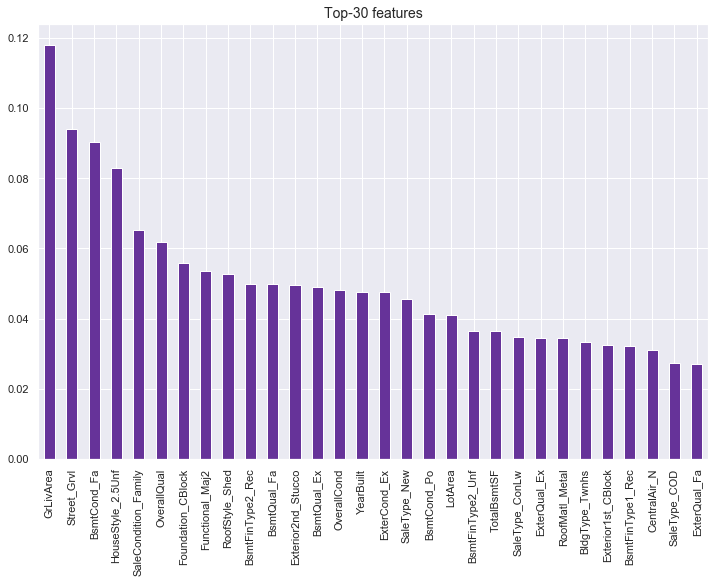

In [7]:
plot_coef_weights(EN_weights, feature_names)

In [96]:
def plot_coef_weights_advanced(coefs_df, n_plot=15):
    
    cum_total = np.cumsum(coefs_df.iloc[:,0])[-1]
    coefs_df = pd.DataFrame(coefs_df.iloc[:n_plot, 0].apply(np.abs))
    
    fig, ax = plt.subplots(figsize=(16, 6))
    plt.bar(np.arange(len(coefs_df)), coefs_df.iloc[:, 0]/cum_total, width = 0.5, align="center", 
            color = 'yellow', label = "Feature Weight")
    plt.bar(np.arange(len(coefs_df)) - 0.3, np.cumsum(coefs_df.iloc[:, 0])/cum_total, width = 0.4, 
            align = "center", color = 'rebeccapurple', label = "Cumulative Feature Weights")
    
    # styling
    plt.title("Top-{0:d} features, with cumulative weights".format(n_plot), size=14)
    plt.ylabel("Prop of total coef weights")
    plt.xlabel("Features / Attributes")
    plt.xticks(np.arange(len(coefs_df)), coefs_df.index, rotation=90)
    plt.legend(loc = 'upper left');
    
    cum_prop = np.cumsum(coefs_df.iloc[:,0])[-1] / cum_total
    print("\nTop-{0:d} features explain {1:2.2f}% of the total coef weights".format(
            n_plot, cum_prop*100))


Top-20 features explain 53.49% of the total coef weights


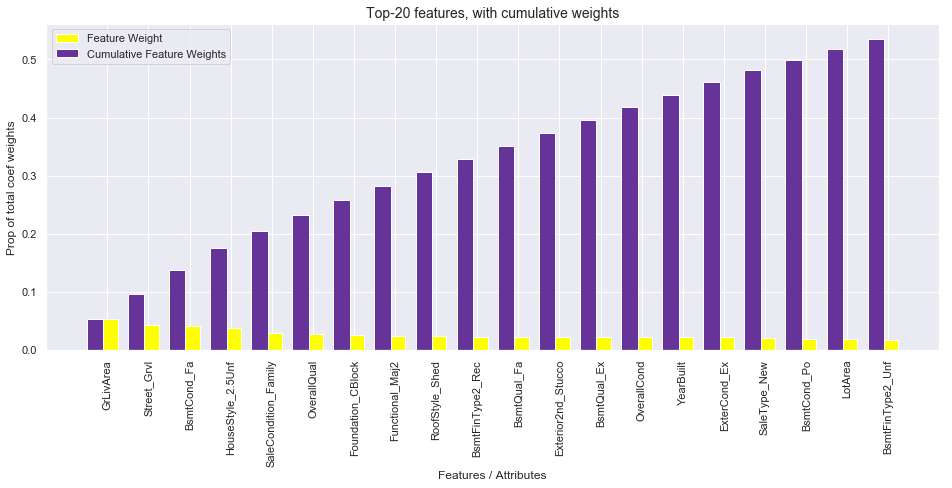

In [100]:
plot_coef_weights_advanced(EN_weights, n_plot=20)

Re-examine feature importance with cumulative weights for categorical features

In [98]:
# Split feature names into category and sub-category
EN_weights['category'] = EN_weights.index.str.split('_').str.get(0)
EN_weights['sub_category'] = EN_weights.index.str.split('_').str.get(-1)
# Group by category and sum the weights
EN_weights['weight'] = EN_weights['weight'].apply(np.abs)
EN_weights_cum = EN_weights.groupby('category').sum()
EN_weights_cum.sort_values('weight', ascending=False, inplace=True)


Top-15 features explain 57.38% of the total coef weights


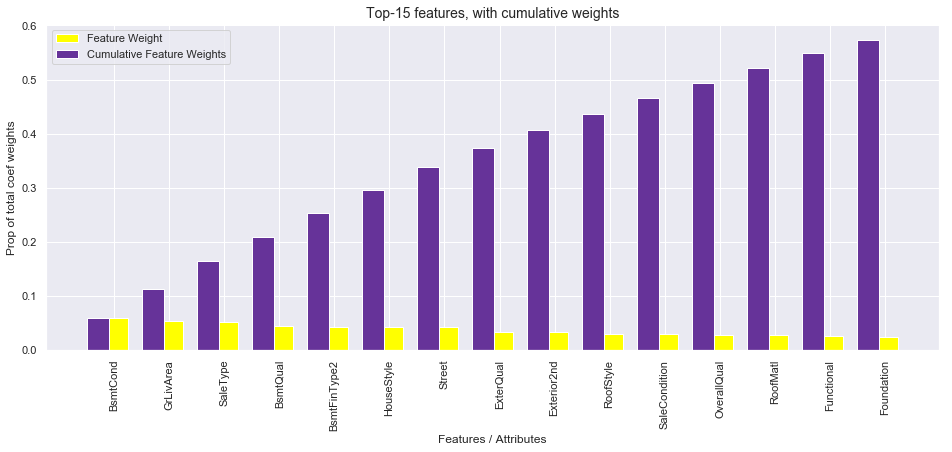

In [99]:
plot_coef_weights_advanced(EN_weights_cum)

In [69]:
test_weights = get_coef_weights(elastic_net_final, feature_names)
len(test_weights)

308

In [78]:
test_weights.cumsum()

,weight
GrLivArea,0.118109
Street_Grvl,0.212062
BsmtCond_Fa,0.302497
HouseStyle_2.5Unf,0.385472
SaleCondition_Family,0.450637
OverallQual,0.512321
Foundation_CBlock,0.456509
Functional_Maj2,0.402902
RoofStyle_Shed,0.455464
BsmtFinType2_Rec,0.505406
